In [0]:
mount = '/content/gdrive'

from google.colab import drive
drive.mount(mount)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy
import math
import glob
from PIL import Image, ImageOps, ImageChops, ImageFilter
import matplotlib.pyplot as plt
import cupy

import chainer
from chainer import training, backend, Variable
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
import chainer.backends.cuda

from IPython.display import clear_output

In [0]:
def gaussian(size):
    return F.gaussian(cupy.zeros(size, dtype=cupy.float32),
                     cupy.ones(size, dtype=cupy.float32))

In [0]:
def make_optimizer_Adam(model, alpha=1e-4, beta1=0.9, clip=True):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    if clip:
        optimizer.add_hook(chainer.optimizer_hooks.GradientClipping(1.))
    return optimizer

In [0]:
def out_generated_image(gen, c_iter, v_iter):
    @chainer.training.make_extension()
    def make_image(trainer):
        clear_output()
        xp = gen.xp
        c_base = c_iter.next()
        z_c = Variable(xp.asarray(c_base))/255. *2. -1.
        v_base = v_iter.next()
        z_v = Variable(xp.asarray(v_base))/255. *2. -1.
        
        with chainer.using_config('train', False):
            x = gen(z_c, z_v)
        x = F.transpose(F.reshape(x, (-1, 3, 256, 256)), (0, 2, 3, 1))
        x = chainer.backends.cuda.to_cpu(x.array)

        plt.figure(figsize=(16, 12))
        
        for i, img in enumerate(c_base):
            plt.subplot(3,4,i+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
            
        for i, img in enumerate(x):
            plt.subplot(3,4,i+5)
            plt.axis('off')
            plt.imshow(Image.fromarray(numpy.uint8((img+1.)/2. *255.)))
            
        for i, img in enumerate(v_base):
            plt.subplot(3,4,i+9)
            plt.axis('off')
            plt.imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
        
        plt.show()
    return make_image

In [0]:
class EncoderDeep(chainer.Chain):

    def __init__(self, wscale=1.):
        super(EncoderDeep, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            w_tanh = chainer.initializers.HeNormal(0.1)
            
            self.c0 = L.Convolution2D(3, 32, 5, 1, 2, initialW=w, nobias=True)
            self.bn0 = L.BatchNormalization(32)
            
            self.c1 = L.Convolution2D(None, 32, 6, 2, 2, initialW=w, nobias=True)
            self.bn1 = L.BatchNormalization(32)
            
            self.c2 = L.Convolution2D(None, 64, 6, 2, 2, initialW=w, nobias=True)
            self.bn2 = L.BatchNormalization(64)
            
            self.c3 = L.Convolution2D(None, 128, 6, 2, 2, initialW=w, nobias=True)
            self.bn3 = L.BatchNormalization(128)
            
            self.c4 = L.Convolution2D(None, 256, 4, 2, 1, initialW=w, nobias=True)
            self.bn4 = L.BatchNormalization(256)
            
            self.c5 = L.Convolution2D(None, 512, 4, 2, 1, initialW=w, nobias=True)
            self.bn5 = L.BatchNormalization(512)
            
            self.c6 = L.Convolution2D(None, 1024, 4, 2, 1, initialW=w, nobias=True)
            self.bn6 = L.BatchNormalization(1024)
            
            self.c7 = L.Convolution2D(None, 2048, 4, 2, 1, initialW=w, nobias=True)
            self.bn7 = L.BatchNormalization(2048)
            
            self.l_mu = L.Linear(None, 1024, initialW=w)
            self.l_var = L.Linear(None, 1024, initialW=w)
            
    def forward(self, z):
        h = F.leaky_relu(self.bn0(self.c0(z)))
        # 256
        h = F.leaky_relu(self.bn1(self.c1(h)))
        # 128
        h = F.leaky_relu(self.bn2(self.c2(h)))
        # 64
        h = F.leaky_relu(self.bn3(self.c3(h)))
        # 32
        h = F.leaky_relu(self.bn4(self.c4(h)))
        # 16
        h = F.leaky_relu(self.bn5(self.c5(h)))
        # 8
        h = F.leaky_relu(self.bn6(self.c6(h)))
        # 4
        h = F.leaky_relu(self.bn7(self.c7(h)))
        # 2
        
        mu = F.tanh(self.l_mu(h))
        var = F.tanh(self.l_var(h))
        
        return mu, var

In [0]:
class EncoderMiddle(chainer.Chain):

    def __init__(self, wscale=1.):
        super(EncoderMiddle, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            w_tanh = chainer.initializers.HeNormal(0.1)
            
            self.c0 = L.Convolution2D(3, 32, 5, 1, 2, initialW=w, nobias=True)
            self.bn0 = L.BatchNormalization(32)
            
            self.c1 = L.Convolution2D(None, 32, 6, 2, 2, initialW=w, nobias=True)
            self.bn1 = L.BatchNormalization(32)
            
            self.c2 = L.Convolution2D(None, 64, 6, 2, 2, initialW=w, nobias=True)
            self.bn2 = L.BatchNormalization(64)
            
            self.c3 = L.Convolution2D(None, 128, 6, 2, 2, initialW=w, nobias=True)
            self.bn3 = L.BatchNormalization(128)
            self.co_32 = L.Convolution2D(None, 8, 1, 1, 0, initialW=w_tanh, nobias=True)
            
            self.c4 = L.Convolution2D(None, 256, 4, 2, 1, initialW=w, nobias=True)
            self.bn4 = L.BatchNormalization(256)
            self.co_16 = L.Convolution2D(None, 32, 1, 1, 0, initialW=w_tanh, nobias=True)
            
            self.l_out = L.Linear(None, 1024, initialW=w)
            
    def forward(self, z):
        batch = z.shape[0]
        h = F.leaky_relu(self.bn0(self.c0(z)))
        # 256
        h = F.leaky_relu(self.bn1(self.c1(h)))
        # 128
        h = F.leaky_relu(self.bn2(self.c2(h)))
        # 64
        
        h = F.leaky_relu(self.bn3(self.c3(h)))
        h_32 = F.reshape(F.leaky_relu(self.co_32(h)), (batch, -1))
        # 32
        
        h = F.leaky_relu(self.bn4(self.c4(h)))
        h = F.reshape(F.leaky_relu(self.co_16(h)), (batch, -1))
        h = F.concat((h, h_32))
        # 16
        
        out = F.tanh(self.l_out(h))
        return out

In [0]:
class AffineTransfer(chainer.Chain):

    def __init__(self, wscale=1.):
        super(AffineTransfer, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.l0 = L.Linear(None, 1024, initialW=w, nobias=True)
            self.l1 = L.Linear(None, 1024, initialW=w, nobias=True)
            self.l2 = L.Linear(None, 1024, initialW=w, nobias=True)
            self.l3 = L.Linear(None, 1024, initialW=w, nobias=True)
            self.l4 = L.Linear(None, 1024, initialW=w, nobias=True)
            self.l5 = L.Linear(None, 1024, initialW=w, nobias=True)
            self.l6 = L.Linear(None, 1024, initialW=w, nobias=True)
            
            self.l_out = L.Linear(None, 1024, initialW=w)

    def forward(self, z):
        h = F.relu(self.l0(z))
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        h = F.relu(self.l4(h))
        h = F.relu(self.l5(h))
        h = F.relu(self.l6(h))
        
        out = F.tanh(self.l_out(h))
        return out

In [0]:
class Discriminator(chainer.Chain):

    def __init__(self, wscale=1.):
        super(Discriminator, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.c0 = L.Convolution2D(3, 32, 5, 1, 2, initialW=w)
            self.bn0 = L.BatchNormalization(32)
            
            self.c1 = L.Convolution2D(None, 32, 6, 2, 2, initialW=w)
            self.bn1 = L.BatchNormalization(32)
            
            self.c2 = L.Convolution2D(None, 64, 6, 2, 2, initialW=w)
            self.bn2 = L.BatchNormalization(64)
            
            self.c3 = L.Convolution2D(None, 128, 6, 2, 2, initialW=w)
            self.bn3 = L.BatchNormalization(128)            
            
            self.l3 = L.Linear(None, 128, initialW=w)     
            self.t_32 = L.Linear(None, 32*4, initialW=None)
            
            self.c4 = L.Convolution2D(None, 256, 4, 2, 1, initialW=w)
            self.bn4 = L.BatchNormalization(256)
            
            self.c5 = L.Convolution2D(None, 512, 4, 2, 1, initialW=w)
            self.bn5 = L.BatchNormalization(512)
            
            self.c6 = L.Convolution2D(None, 1024, 4, 2, 1, initialW=w)
            self.bn6 = L.BatchNormalization(1024)
            
            self.l6 = L.Linear(None, 1024, initialW=w)     
            self.t_4 = L.Linear(None, 64*16, initialW=None)
            
            self.l_o = L.Linear(None, 1, initialW=w)

    def minibatch_discrimination(self, m):
        m = F.expand_dims(m, 3)
        m_T = F.transpose(m, (3, 1, 2, 0))
        m, m_T = F.broadcast(m, m_T)
        norm = F.sum(F.absolute_error(m, m_T), axis=2)
        eraser = F.broadcast_to(cupy.eye(batchsize, dtype=cupy.float32).reshape((batchsize, 1, batchsize)), norm.shape)
        c_b = F.exp(-(norm + 1e6 * eraser))
        o_b = F.sum(c_b, axis=2)
        return o_b
        
    def forward(self, z):
        batchsize = z.shape[0]
        h = F.leaky_relu(self.bn0(self.c0(F.gaussian(z, cupy.ones(z.shape, dtype=cupy.float32)*1e-1))))
        h = F.leaky_relu(self.bn1(self.c1(F.gaussian(h, cupy.ones(h.shape, dtype=cupy.float32)*1e-1))))
        h = F.leaky_relu(self.bn2(self.c2(F.gaussian(h, cupy.ones(h.shape, dtype=cupy.float32)*1e-1))))
        h_32 = F.leaky_relu(self.bn3(self.c3(F.gaussian(h, cupy.ones(h.shape, dtype=cupy.float32)*1e-1))))
        
        h = self.l3(h_32)
        m = F.reshape(self.t_32(h), (batchsize, 32, 4))
        o_b_32 = self.minibatch_discrimination(m)
        
        h = F.leaky_relu(self.bn4(self.c4(F.gaussian(h_32, cupy.ones(h_32.shape, dtype=cupy.float32)*1e-1))))
        h = F.leaky_relu(self.bn5(self.c5(F.gaussian(h, cupy.ones(h.shape, dtype=cupy.float32)*1e-1))))
        h_4 = F.leaky_relu(self.bn6(self.c6(F.gaussian(h, cupy.ones(h.shape, dtype=cupy.float32)*1e-1))))
        
        h = self.l6(h_4)
        m = F.reshape(self.t_4(h), (batchsize, 64, 16))
        o_b_4 = self.minibatch_discrimination(m)
        
        h = F.concat((h, o_b_4, o_b_32), axis=1)
        
        return self.l_o(h), h_4, h_32

In [0]:
class Decoder(chainer.Chain):

    def __init__(self, wscale=1.):
        super(Decoder, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            w_out = chainer.initializers.HeNormal(wscale*1e-1)
            
            self.l_s32 = L.Linear(None, 128*128, initialW=w, nobias=True)
            self.l_b32 = L.Linear(None, 32*32, initialW=w, nobias=True)
            self.bn_32 = L.BatchNormalization(129)
            
            self.l_s128 = L.Linear(None, 64*32, initialW=w, nobias=True)
            self.l_b128 = L.Linear(None, 128*128, initialW=w, nobias=True)
            self.bn_128 = L.BatchNormalization(33)
            
            self.l_z4 = L.Linear(None, 2048*2*2, initialW=w, nobias=True)
            self.dc1 = L.Deconvolution2D(None, 1024, 4, 2, 1, initialW=w, nobias=True)
            self.bn1 = L.BatchNormalization(1024)
            # 4
            
            self.dc2 = L.Deconvolution2D(None, 512, 4, 2, 1, initialW=w, nobias=True)
            self.bn2 = L.BatchNormalization(512)
            # 8
            
            self.dc3 = L.Deconvolution2D(None, 256, 4, 2, 1, initialW=w, nobias=True)
            self.bn3 = L.BatchNormalization(256)
            # 16
            
            self.dc4 = L.Deconvolution2D(None, 128, 4, 2, 1, initialW=w, nobias=True)
            self.bn4 = L.BatchNormalization(128)
            # 32
            
            self.dc5 = L.Deconvolution2D(None, 128, 6, 2, 2, initialW=w, nobias=True)
            self.bn5 = L.BatchNormalization(128)
            #64
            
            self.dc6 = L.Deconvolution2D(None, 64, 6, 2, 2, initialW=w, nobias=True)
            self.bn6 = L.BatchNormalization(64)
            # 128
            
            self.dc7 = L.Deconvolution2D(None, 32, 6, 2, 2, initialW=w, nobias=True)
            self.bn7 = L.BatchNormalization(32)
            
            self.c_out = L.Convolution2D(None, 3, 1, 1, 0, initialW=w)
            # 256
      
    def mul(self, z, n):
        batch, ch, w, h = z.shape
        z = F.reshape(z, (batch, ch, -1))
        _, _, ch = n.shape
        z = F.batch_matmul(z, n, transa=True)
        z = F.transpose(z, (0, 2, 1))
        return F.reshape(z, (batch, ch, w, h))

    def forward(self, z_2, z_32, z_128):
        batch = z_2.shape[0]
        h = F.reshape(F.relu(self.l_z4(z_2)) ,(batch, -1, 2, 2))
        h = F.relu(self.bn1(self.dc1(h)))
        # 4
        
        h = F.relu(self.bn2(self.dc2(h)))
        # 8
        
        h = F.relu(self.bn3(self.dc3(h)))
        # 16
        
        n = F.reshape(gaussian(batch*16*16), (batch, 1, 16, 16))
        h = F.relu(self.bn4(self.dc4(F.concat((h, n)))))
        
        n = F.reshape(self.l_s32(z_32) ,(batch, 128, -1))
        h = self.mul(h, n)
        
        n = F.reshape(self.l_b32(z_32) ,(-1, 1, 32, 32))
        h = self.bn_32(F.concat((h, n)))
        # 32
        
        h = F.relu(self.bn5(self.dc5(h)))
        # 64
        
        n = F.reshape(gaussian(batch*64*64), (batch, 1, 64, 64))
        h = F.relu(self.bn6(self.dc6(F.concat((h, n)))))
        
        n = F.reshape(self.l_s128(z_128) ,(batch, 64, -1))
        h = self.mul(h, n)
        
        n = F.reshape(self.l_b128(z_128) ,(-1, 1, 128, 128))
        h = self.bn_128(F.concat((h, n)))
        # 128
        
        h = F.relu(self.bn7(self.dc7(h)))
        # 256
        
        h = F.tanh(self.c_out(h))
        return h

In [0]:
class Generator(chainer.Chain):

    def __init__(self, encoder_deep, encoder_middle, affine_transfer, decoder):
        super(Generator, self).__init__()
        self.encoder_deep = encoder_deep
        self.encoder_middle = encoder_middle
        self.affine_transfer = affine_transfer
        self.decoder = decoder

    def forward(self, x_c, x_v):
        batch = x_c.shape[0]
        mu_c, var_c = self.encoder_deep(x_c)
        h_c = F.gaussian(mu_c, var_c)
        h_v = self.encoder_middle(x_v)
        h_v = self.affine_transfer(h_v)
        s_128 = F.reshape(gaussian(batch*16), (-1, 16))
        return self.decoder(h_c, h_v, s_128)

In [0]:
class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis= kwargs.pop('models')
        self.cache_fake = None
        self.cache_dis = None
        self.k = 5
        super(DCGANUpdater, self).__init__(*args, **kwargs)
        
    def gram(self, x):
        batch, ch, height, width = x.shape
        feature = F.reshape(x, (batch, ch, -1))
        return F.batch_matmul(feature, feature, transb=True) / (ch*height*width)

    def loss_dis(self, dis, ll, opt):
        loss = sum(ll)
        chainer.report({opt: loss}, dis)
        return loss
    
    def loss_en(self, en, ll):
        loss = sum(ll) 
        chainer.report({'loss': loss, 'lat': ll[1]}, en)
        return loss
    
    def loss_de(self, de, ll):
        loss = sum(ll) 
        chainer.report({'loss': loss, 'fake': ll[0]}, de)
        return loss

    def update_core(self):
        en_d_optimizer = self.get_optimizer('en_d')
        en_m_optimizer = self.get_optimizer('en_m')
        affine_t_optimizer = self.get_optimizer('affine_t')
        dis_optimizer = self.get_optimizer('dis')
        de_optimizer = self.get_optimizer('de')
        
        gen, dis = self.gen, self.dis
        
        for _ in range(self.k):
            batch_c = self.get_iterator('main').next()
            batchsize = len(batch_c)
            x_c_real = Variable(self.converter(batch_c, device=self.device)) /255. *2. -1.

            batch_v = self.get_iterator('middle').next()
            x_v_real = Variable(self.converter(batch_v, device=self.device)) /255. *2. -1.
            
            mu_c_real, var_c_real = gen.encoder_deep(x_c_real)
            h_c_real = F.gaussian(mu_c_real, var_c_real)

            h_v_real = gen.encoder_middle(x_v_real)
            h_v_at = gen.affine_transfer(h_v_real)

            s_128_real = F.reshape(gaussian(batchsize*16), (-1, 16))

            x_fake = gen.decoder(h_c_real, h_v_at, s_128_real)
            
            y_c_real, fm4_c_real, _ = dis(x_c_real)
            dis_loss_real = F.sum((y_c_real-1)**2) / batchsize
            dis_optimizer.update(self.loss_dis, dis, [dis_loss_real], 'c_real')

            y_v_real, _, fm32_v_real = dis(x_v_real)
            dis_loss_real = F.sum((y_v_real-1)**2) / batchsize
            dis_optimizer.update(self.loss_dis, dis, [dis_loss_real], 'v_real')
            
            y_fake, fm4_fake, fm32_fake = dis(x_fake)
            dis_loss_fake = F.sum(y_fake**2) / batchsize
            dis_optimizer.update(self.loss_dis, dis, [dis_loss_fake], 'fake')
        
            if self.cache_fake is not None:
                remind, _, _ = dis(self.cache_fake)
                dis_loss_remind = F.sum(remind**2) / batchsize
                dis_optimizer.update(self.loss_dis, dis, [dis_loss_remind], 'remind')
                
            if self.cache_dis is None:
                self.cache_dis = dis.copy('copy')
                
        dis.copyparams(self.cache_dis)
        self.cache_dis = None
        
        latent_loss = F.mean(F.gaussian_kl_divergence(mu_c_real, var_c_real)) / batchsize *1e-3
        fake_loss = F.sum((y_fake-1)**2) / batchsize
        fm4_loss = F.mean_squared_error(fm4_c_real, fm4_fake)
        fm32_loss = F.mean_squared_error(fm32_v_real, fm32_fake)
        
        en_d_optimizer.update(self.loss_en, gen.encoder_deep, [fm4_loss, latent_loss])
        en_m_optimizer.update(self.loss_de, gen.encoder_middle, [fm32_loss])
        affine_t_optimizer.update(self.loss_de, gen.affine_transfer, [fm32_loss])
        de_optimizer.update(self.loss_de, gen.decoder, [fake_loss, fm4_loss, fm32_loss])
        
        self.cache_fake = x_fake
        
        # style_loss = F.mean_squared_error(self.gram(x_real), self.gram(x_fake))
        # reconst_loss = F.mean(F.bernoulli_nll(x_c_real, x_fake)) / batchsize *1e-5

In [0]:
GPU = 0
OUT = mount+'/My Drive/result/'
IMG_SHAPE = (256, 256)

In [0]:
iteration = 500
batchsize = 16
snapshot_interval = 20
display_interval = 20
update_interval = 20

In [0]:
dataset = mount+'/My Drive/picture/train_pic/**/*.jpg'

In [0]:
gen = Generator(encoder_deep=EncoderDeep(), encoder_middle=EncoderMiddle(), affine_transfer=AffineTransfer(), decoder=Decoder())
dis = Discriminator()

In [0]:
chainer.backends.cuda.get_device_from_id(GPU).use()
gen.to_gpu()
gen.encoder_deep.to_gpu()
gen.encoder_middle.to_gpu()
gen.affine_transfer.to_gpu()
gen.decoder.to_gpu()
dis.to_gpu()

In [0]:
opt_en_d = make_optimizer_Adam(gen.encoder_deep, clip=False)
opt_en_m = make_optimizer_Adam(gen.encoder_middle, clip=False)
opt_affine_t = make_optimizer_Adam(gen.affine_transfer, clip=False)
opt_de = make_optimizer_Adam(gen.decoder, clip=False)
opt_dis = make_optimizer_Adam(dis, clip=False)
dis.t_4.disable_update()
dis.t_32.disable_update()

In [0]:
def crop_sq(img):
    img_width, img_height = img.size
    sub = img_width - img_height
    if sub == 0:
        return img
    crop_size = min(img.size)
    crop_position = numpy.random.randint(0, abs(sub))
    if sub > 0:
        return img.crop((crop_position, 0, crop_size+crop_position, crop_size))
    else:
        return img.crop((0, crop_position, crop_size, crop_size+crop_position))

In [0]:
def img_convert(img_array):
    img = Image.fromarray(numpy.uint8(img_array.transpose(1, 2, 0))).convert('RGB')
    width, height = img.size
    image_trans_trigger = numpy.random.randn(2)
    
    img = crop_sq(img)
        
    if image_trans_trigger[0] > 0:
        img = ImageOps.mirror(img)
        
    if image_trans_trigger[1] == 0.:
        img = img.resize(IMG_SHAPE)
    else:
        img = img.resize((IMG_SHAPE[0]+64, IMG_SHAPE[1]+64))
        crop_position = numpy.random.randint(0, 64, 2)
        img = img.crop((crop_position[0],
                       crop_position[1],
                       crop_position[0]+IMG_SHAPE[0],
                       crop_position[1]+IMG_SHAPE[1]))

    out_array = numpy.asarray(img, dtype=numpy.float32).transpose(2, 0, 1)
    return out_array

In [0]:
def img_resize(img_array):
    img = Image.fromarray(numpy.uint8(img_array.transpose(1, 2, 0))).convert('RGB')
    img = crop_sq(img)
      
    img = img.resize(IMG_SHAPE)
    out_array = numpy.asarray(img, dtype=numpy.float32).transpose(2, 0, 1)
    return out_array

In [0]:
image_files = glob.glob(dataset, recursive=True)
print('{} contains {} image files'
      .format(dataset, len(image_files)))
img_dataset = chainer.datasets.ImageDataset(paths=image_files)

train = chainer.datasets.TransformDataset(img_dataset, img_convert)
sample = chainer.datasets.TransformDataset(img_dataset, img_resize)

/content/gdrive/My Drive/picture/train_pic/**/*.jpg contains 41986 image files


In [0]:
train_c_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)
train_v_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)

In [0]:
updater = DCGANUpdater(
    models=(gen, dis),
    iterator={'main': train_v_iter, 'middle': train_c_iter},
    optimizer={'de': opt_de, 'en_d': opt_en_d, 'en_m': opt_en_m, 'affine_t': opt_affine_t, 'dis': opt_dis},
    device=GPU)

In [0]:
trainer = training.Trainer(updater, (iteration, 'iteration'), out=OUT)

In [0]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')

In [0]:
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(out_generated_image(gen,
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True),
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True)),
               trigger=snapshot_interval)
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'en_d/loss', 'en_d/lat', 'en_m/loss', 'dis/c_real', 'dis/v_real', 'dis/fake', 'de/loss', 'de/fake'
    ]), trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=update_interval))

In [0]:
if True:
    chainer.serializers.load_npz(OUT+'hobo_en_d.npz', gen.encoder_deep, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_en_m.npz', gen.encoder_middle, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_affine_t.npz', gen.affine_transfer, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_de.npz', gen.decoder, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_dis.npz', dis, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_opt_en_d.npz', opt_en_d, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_opt_en_m.npz', opt_en_m, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_opt_affine_t.npz', opt_affine_t, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_opt_de.npz', opt_de, strict=False)
    chainer.serializers.load_npz(OUT+'hobo_opt_dis.npz', opt_dis, strict=False)

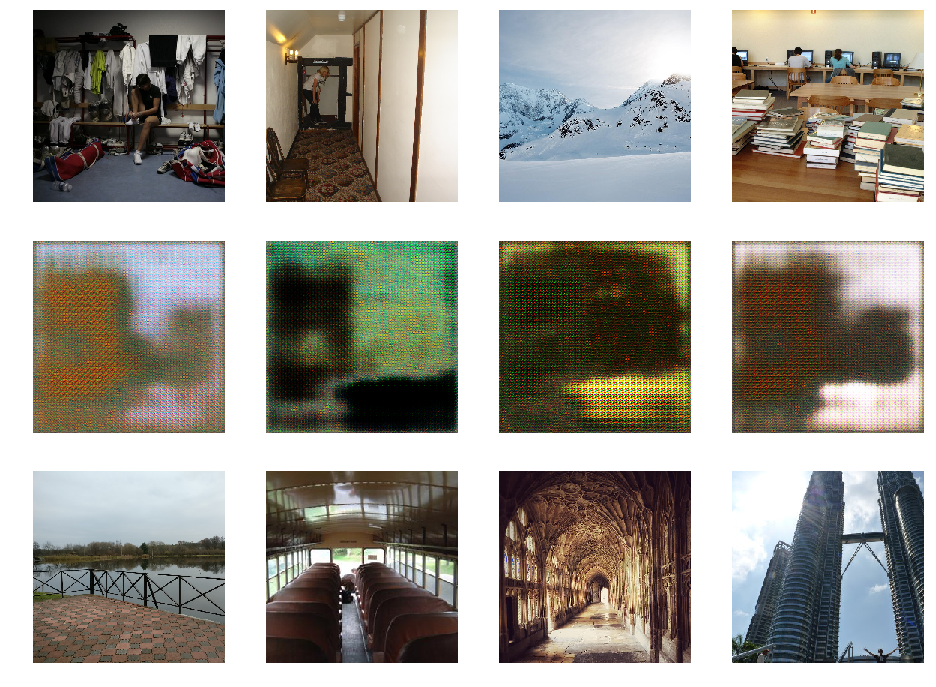

0           100         0.743739    0.0237361   0.910971    0.141023    0.0740924   0.275257    5.22338     3.5924      
     total [##########........................................] 20.00%
this epoch [#########.........................................] 19.05%
       100 iter, 0 epoch / 500 iterations
  0.010636 iters/sec. Estimated time to finish: 10:26:48.891660.


In [0]:
trainer.run()

In [0]:
if True:
    chainer.serializers.save_npz(OUT+'hobo_en_d.npz', gen.encoder_deep)
    chainer.serializers.save_npz(OUT+'hobo_en_m.npz', gen.encoder_middle)
    chainer.serializers.save_npz(OUT+'hobo_affine_t.npz', gen.affine_transfer)
    chainer.serializers.save_npz(OUT+'hobo_de.npz', gen.decoder)
    chainer.serializers.save_npz(OUT+'hobo_dis.npz', dis)
    chainer.serializers.save_npz(OUT+'hobo_opt_en_d.npz', opt_en_d)
    chainer.serializers.save_npz(OUT+'hobo_opt_en_m.npz', opt_en_m)
    chainer.serializers.save_npz(OUT+'hobo_opt_affine_t.npz', opt_affine_t)
    chainer.serializers.save_npz(OUT+'hobo_opt_de.npz', opt_de)
    chainer.serializers.save_npz(OUT+'hobo_opt_dis.npz', opt_dis)